In [1]:
import os, time, glob, imageio
import tensorflow as tf
from tensorflow.keras import layers
from tqdm import tqdm
from IPython import display
import matplotlib.pyplot as plt
from PIL import Image

E0000 00:00:1755427193.380310    3996 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:230


In [ ]:
!pip install imageio
# 1. Install the Kaggle library
!pip install kaggle -q

# 3. Move the file to the required directory and set permissions
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
print("\n✅ Kaggle API is set up successfully!")
# API command to download the CelebA dataset
# This downloads a file named 'celeba-dataset.zip'
!kaggle datasets download -d jessicali9530/celeba-dataset

# Unzip the downloaded file. The -q flag makes the output quiet.
print("Unzipping the dataset... This may take several minutes.")

!unzip -q celeba-dataset.zip

print("\n✅ Dataset unzipped successfully!")

In [2]:
DATASET_PATH = '/kaggle/working/img_align_celeba/img_align_celeba'
SAVE_PATH = './generated_images'

IMG_WIDTH = 64
IMG_HEIGHT = 64
IMG_CHANNELS = 3

LATENT_DIM = 100
EPOCHS = 50
BATCH_SIZE = 128
BUFFER_SIZE = 200000

if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
    print("TPU strategy is active.")
except Exception as e:
    strategy = tf.distribute.get_strategy()
    print("TPU not found. Using default strategy.", e)

GLOBAL_BATCH_SIZE = BATCH_SIZE * strategy.num_replicas_in_sync
print(f"Global batch size: {GLOBAL_BATCH_SIZE}")

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1755427202.130466    3996 service.cc:148] XLA service 0x5677cd9e0ed0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755427202.130511    3996 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1755427202.130516    3996 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1755427202.130519    3996 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1755427202.130522    3996 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1755427202.130524    3996 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1755427202.130527    3996 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1755427202.130529    3996 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1755427202.130532    3996 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [3]:
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = (image - 127.5) / 127.5
    return image

train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    labels=None,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=GLOBAL_BATCH_SIZE,
    interpolation='nearest'
)

train_dataset = (
    train_dataset
    .unbatch()
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(BUFFER_SIZE)
    .batch(GLOBAL_BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

train_dist_dataset = strategy.experimental_distribute_dataset(train_dataset)

Found 202599 files.


In [4]:
with strategy.scope():
    def make_generator_model():
        model = tf.keras.Sequential([
            layers.Dense(4*4*1024, use_bias=False, input_shape=(LATENT_DIM,)),
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Reshape((4, 4, 1024)),
            layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Conv2DTranspose(IMG_CHANNELS, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
        ])
        return model

    def make_discriminator_model():
        model = tf.keras.Sequential([
            layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS]),
            layers.LeakyReLU(),
            layers.Dropout(0.3),
            layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
            layers.LeakyReLU(),
            layers.Dropout(0.3),
            layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
            layers.LeakyReLU(),
            layers.Dropout(0.3),
            layers.Flatten(),
            layers.Dense(1)
        ])
        return model

    generator = make_generator_model()
    discriminator = make_discriminator_model()

    generator_optimizer = tf.keras.optimizers.Adam(1e-4)
    discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

    cross_entropy = tf.keras.losses.BinaryCrossentropy(
        from_logits=True,
        reduction=tf.keras.losses.Reduction.NONE
    )

    def discriminator_loss(real_output, fake_output):
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return tf.nn.compute_average_loss(total_loss, global_batch_size=GLOBAL_BATCH_SIZE)

    def generator_loss(fake_output):
        loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        return tf.nn.compute_average_loss(loss, global_batch_size=GLOBAL_BATCH_SIZE)

seed = tf.random.normal([16, LATENT_DIM])

/usr/local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1755427222.712555    3996 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/usr/local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


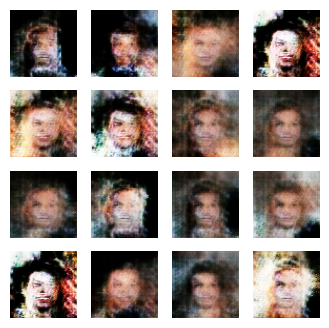

Time for epoch 50 is 15.36 seconds


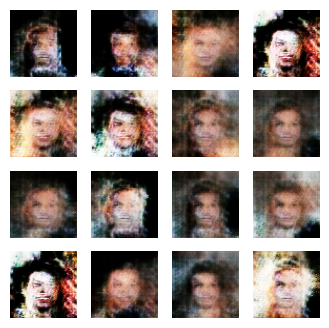

/tmp/ipykernel_3996/449289749.py:52: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


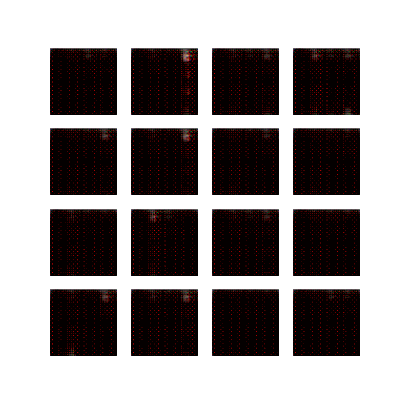

In [5]:
with strategy.scope():
    def train_step(images):
        local_bs = tf.shape(images)[0]
        noise = tf.random.normal([local_bs, LATENT_DIM])
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = generator(noise, training=True)
            real_output = discriminator(images, training=True)
            fake_output = discriminator(generated_images, training=True)
            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    @tf.function
    def distributed_train_step(dist_inputs):
        strategy.run(train_step, args=(dist_inputs,))


def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    predictions = (predictions + 1) / 2.0
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')
    image_path = os.path.join(SAVE_PATH, f'image_at_epoch_{epoch:04d}.png')
    plt.savefig(image_path)
    display.display(plt.gcf())
    plt.close(fig)


def train(dataset, epochs):
    for epoch in range(epochs):
        start_time = time.time()
        progress_bar = tqdm(dataset, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch")
        for image_batch in progress_bar:
            distributed_train_step(image_batch)
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        print(f'Time for epoch {epoch + 1} is {time.time() - start_time:.2f} seconds')
    generate_and_save_images(generator, epochs, seed)

train(train_dist_dataset, EPOCHS)

anim_file = os.path.join(SAVE_PATH, 'dcgan.gif')
with imageio.get_writer(anim_file, mode='I', duration=0.2, loop=0) as writer:
    filenames = sorted(glob.glob(os.path.join(SAVE_PATH, 'image*.png')))
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

display.display(Image.open(anim_file))